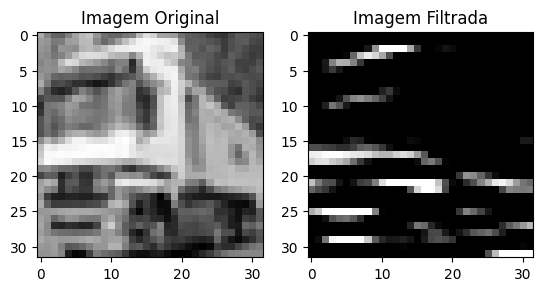

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Função para gerar o filtro Gabor
def gabor_filter(ksize, sigma, theta, lambda_, gamma, psi):
    # Filtro Gabor
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambda_, gamma, psi, ktype=cv2.CV_32F)
    return kernel

ksize = 5        # kernel pequeno, pois as imagens são pequenas (3x3 seria pequeno demais)
sigma = 2.0      # menor sigma para evitar borramento excessivo
lambda_ = 4.0    # frequência mais curta (melhor para detalhes em imagens pequenas)
gamma = 0.8      # menos anisotrópico (mantém formato quase circular)
psi = 0          # fase padrão
theta = np.pi/2 # 4 orientações principais
# Gerar o filtro
gabor_kernel = gabor_filter(ksize, sigma, theta, lambda_, gamma, psi)

# Carregar uma imagem (exemplo com uma imagem simples)
image = cv2.imread('datasets/cifar-10-exemplos/cifar10_truck.png', cv2.IMREAD_GRAYSCALE)

# Aplicar o filtro Gabor na imagem
filtered_image = cv2.filter2D(image, cv2.CV_8UC3, gabor_kernel)

# Mostrar a imagem original e a imagem filtrada
plt.subplot(1, 2, 1), plt.imshow(image, cmap='gray'), plt.title('Imagem Original')
plt.subplot(1, 2, 2), plt.imshow(filtered_image, cmap='gray'), plt.title('Imagem Filtrada')
plt.show()


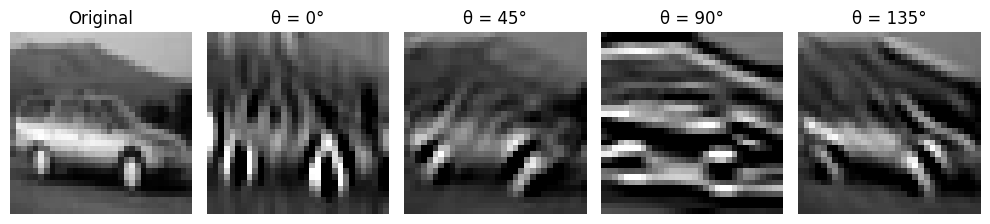

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def build_gabor_bank(ksize=5, sigma=2.0, lambd=4.0, gamma=0.8, psi=0):
    thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    filters = []
    for theta in thetas:
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
        kern /= 1.5 * kern.sum()  # normaliza o kernel
        filters.append(kern)
    return filters

def apply_gabor_filters(img, filters):
    responses = [cv2.filter2D(img, cv2.CV_8UC3, k) for k in filters]
    return np.stack(responses, axis=-1)

# --- Carregar imagem ---
img = cv2.imread("datasets/cifar-10-exemplos/cifar10_automobile.png", cv2.IMREAD_GRAYSCALE)

# --- Criar e aplicar filtros ---
filters = build_gabor_bank()
responses = apply_gabor_filters(img, filters)

# --- Plotar resultados ---
plt.figure(figsize=(10, 3))
plt.subplot(1, len(filters) + 1, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

# Mostrar cada resposta
for i, resp in enumerate(responses.transpose(2, 0, 1)):
    plt.subplot(1, len(filters) + 1, i + 2)
    plt.imshow(resp, cmap='gray')
    plt.title(f'θ = {i * 45}°')
    plt.axis('off')

plt.tight_layout()
plt.show()


# Combina as respostas (por exemplo, média)
feature_map = np.mean(responses, axis=-1)


In [5]:
from matplotlib import pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
import numpy as np
from time import time
import os

from utils.arquivo_utils import ArquivoUtils
from utils.enums.datasets_name_enum import DatasetName


# ==============================
# Função: aplicar Gabor numa imagem Torch
# ==============================
def aplicar_gabor(img_tensor: torch.Tensor, theta=0) -> torch.Tensor:
    """
    Aplica o filtro de Gabor em uma imagem Torch (C,H,W) e retorna tensor [1,H,W]
    """
    # Converter (C,H,W) -> (H,W,C)
    img = img_tensor.permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)

    # Converter para escala de cinza
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Criar o kernel Gabor (θ=45°)
    ksize = 5
    sigma = 2.0
    lambd = 4.0
    gamma = 0.8
    psi = 0
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
    kernel /= 1.5 * kernel.sum()

    # Aplicar o filtro Gabor
    filtered = cv2.filter2D(gray, cv2.CV_32F, kernel)

    # Normalizar para [0,1]
    filtered = cv2.normalize(filtered, None, 0, 1, cv2.NORM_MINMAX)

    # Converter para tensor Torch [1,H,W]
    gabor_tensor = torch.from_numpy(filtered).unsqueeze(0).float()
    return gabor_tensor


# ==============================
# Função: extrair e salvar features
# ==============================
def extrair_gabor_features(loader, nome_split="train", theta=np.pi/4):
    feats, labels = [], []
    for i, (imgs, lbls) in enumerate(loader):
        # imgs: [B,C,H,W]
        gabor_batch = []
        for img in imgs:
            gabor_img = aplicar_gabor(img, theta=theta)
            gabor_batch.append(gabor_img)

        gabor_batch = torch.stack(gabor_batch)  # [B,1,H,W]
        B, C, H, W = gabor_batch.shape

        # Flatten (cada imagem vira um vetor 1D)
        gabor_flat = gabor_batch.view(B, -1).numpy()
        feats.append(gabor_flat)
        labels.append(lbls.numpy())

        print(f"\rProcessando {nome_split}: {i+1}/{len(loader)}", end="", flush=True)

    print()  # quebra linha
    X = np.concatenate(feats, axis=0)
    y = np.concatenate(labels, axis=0)
    print(f"{nome_split} -> {X.shape[0]} amostras, dimensão {X.shape[1]}")
    return X, y


# ==============================
# Main
# ==============================
if __name__ == "__main__":
    start = time()

    # CIFAR-10
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    trainset = torchvision.datasets.CIFAR10(root="./datasets", train=True, download=False, transform=transform)
    testset = torchvision.datasets.CIFAR10(root="./datasets", train=False, download=False, transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=False)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

    # Extrair Gabor features (θ = 45°)
    X_train, y_train = extrair_gabor_features(trainloader, "train", theta=3*np.pi/4)
    X_test, y_test = extrair_gabor_features(testloader, "test", theta=3*np.pi/4)

    # Salvar as features
    ArquivoUtils.salvar_features_imagem(
        nome_tecnica_ext=f"gabor_theta130",
        nome_dataset=DatasetName.CIFAR10.value,
        dados_treino=X_train,
        classes_treino=y_train,
        dados_teste=X_test,
        classes_teste=y_test
    )

    end = time()
    print(f"\n✅ Concluído! Tempo total: {end - start:.2f}s")
    print("Arquivo salvo em: features/cifar10_gabor_theta45_features.npz")


Processando train: 391/391
train -> 50000 amostras, dimensão 1024
Processando test: 79/79
test -> 10000 amostras, dimensão 1024

✅ Concluído! Tempo total: 41.67s
Arquivo salvo em: features/cifar10_gabor_theta45_features.npz
